(cost_sensitive_learning)=

# Cost-Sensitive Learning

In practice, we often associate different costs with different types of mistakes. Cost-sensitive learning is a way to explicitly take into account different valuations of mistakes during model training and selection.

## Optimizing the Decision Threshold

In binary classification, the decision threshold is the cut-off value of the model's confidence score at which an instance is classified as positive. The choice of decision threshold can be an important tool to control the trade-off between false positives and false negatives. Let's see how varying the decision threshold affects the model's accuracy, true positive rate, and true negative rate on the test data.

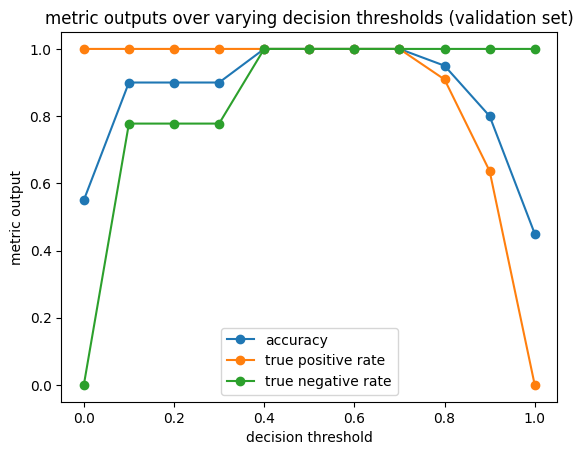

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import true_positive_rate, true_negative_rate
import matplotlib.pyplot as plt

# create synthethic data set
X, y = make_classification(random_state=1)

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=1)
# further split into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
  X_train, y_train, test_size=0.25, random_state=3)

# train logistic regression classifier on training data
clf = LogisticRegression()
clf.fit(X_train, y_train)

# compute and plot validation set performance at different decision thresholds
y_score = clf.predict_proba(X_val)[:, 1]
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
metrics = {'accuracy' : accuracy_score,
           'true positive rate' : true_positive_rate,
           'true negative rate' : true_negative_rate,
           }
for metric_name, metric_function in metrics.items():
  metric_output = [metric_function(y_true=y_val, y_pred=y_score>=t) for t in thresholds]
  plt.plot(thresholds, metric_output, 'o-', label=metric_name)
plt.title("metric outputs over varying decision thresholds (validation set)")
plt.xlabel("decision threshold")
plt.ylabel("metric output")
plt.legend()
plt.show()

In the example above, we clearly see a trade-off between the true positive rate and the true negative rate. At lower decision thresholds, more instances are classified as positives. As such, we are also able to correctly identify more _true_ positives. At the extreme $t=0$, _all_ instances are classified as positive, resulting in $tpr=1$. At higher decision thresholds, more instances are classified as negatives. As a result, the number of true negatives increases, but the number of true positives decreases. Again, at the extreme $t=1$, all instances are classified as negatives, resulting in $tnr=1$.

In our example, it seems that the default decision threshold in scikit-learn, $t=0.5$, provides a good balance between the number of false positives and false negatives. In practice, however, the default decision threshold may not represent an adequate trade-off. For example, the predicted scores may be skewed towards lower or higher values, making $t=0.5$ a suboptimal choice. In other cases, we may not value false positives and false negatives equally and, as such, prefer to trade off one for the other by decreasing or increasing the decision threshold.

```{note}
:class: seealso

The decision threshold should always be selected based on a _validation_ data, not _training_ data. Why this is an essential part of a proper machine learning pipeline will be explained in more detail in chapter [Model Selection](model_selection).
```

```{note}
:class: seealso

The Python library *scikit-lego* provides a useful wrapper class, {py:class}`sklego.meta.Thresholder`, that can be used to optimize a model's decision threshold within a scikit-learn cross-validation pipeline.
```

## Cost-Sensitive Learning Algorithms

It is often also possible to directly take into account misclassification cost during learning. In particular, it may be possible to weigh instances of a particular class differently in the algorithm's loss function. For example, {py:class}`sklearn.linear_model.LogisticRegression` has a `class_weight` parameter that allows to adjust the weight for each class.

In [2]:
for class_weight in [{0:10, 1:1}, {0:1, 1:10}, {0:1, 1:1}]:
    clf = LogisticRegression(class_weight=class_weight)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print('class_weight {}'.format(class_weight))
    print('  tpr : {:.2f}'.format(true_positive_rate(y_true=y_val, y_pred=y_pred)))
    print('  tnr : {:.2f}'.format(true_negative_rate(y_true=y_val, y_pred=y_pred)))

class_weight {0: 10, 1: 1}
  tpr : 0.91
  tnr : 1.00
class_weight {0: 1, 1: 10}
  tpr : 1.00
  tnr : 0.78
class_weight {0: 1, 1: 1}
  tpr : 1.00
  tnr : 1.00


## Sampling Approaches

Similar to cost-sensitive learning, oversampling and undersampling techniques serve to emphasize one class over another. Oversampling techniques increase the number of samples in the data set of the minority class, whereas undersampling techniques decrease the number of samples in the majority calss.

The most naive sampling approaches use _random resampling_, in which instances in the original training data set are randomly selected. In case of random oversampling, instances of the minority class are randomly selected and duplicated. _Random undersampling_, on the other hand, randomly deletes instances of the majority class from the data set. More sophisticasted approaches, such as SMOTE or prototypes, generate synthetic examples to achieve a more 'balanced' data set.

```{note}
:class: seealso

The Python library [`imbalanced-learn`](https://imbalanced-learn.org/stable/) implements various oversampling and undersampling approaches.
```